# Arabic Dialect Identification - Applying Machine Learning
## By Karim Elshetihy
- [Github](https://github.com/KarimElshetihy)
- [Linkedin](https://www.linkedin.com/in/karim-el-shetihy/)

#### Referances:
- [Arabic Dialict Identification in the Wild Paper](https://arxiv.org/pdf/2005.06557.pdf)
- [Flask Tutorial](https://programminghistorian.org/en/lessons/creating-apis-with-python-and-flask)
- [Multinomial Classification](https://towardsdatascience.com/the-complete-guide-to-neural-networks-multinomial-classification-4fe88bde7839)
- [Multi-class text classification model with Keras](https://www.design-ai.de/blog-posts/multi-class-text-classification-model-with-keras)
- [Word Embedding and Text Vectorization](https://www.analyticsvidhya.com/blog/2021/06/part-5-step-by-step-guide-to-master-nlp-text-vectorization-approaches/)


#### The Dataset:
The dataset and the dialect identification problem were addressed by Qatar Computing Research Institute, moreover, they published a paper, feel free to get more insights from it [Here](https://arxiv.org/pdf/2005.06557.pdf).

We are given a dataset which has 2 columns, **id** and **dialect**.
- Target label column is the **dialect***, which has 18 classes.
- The **id** column will be used to retrieve the text, to do that, you need to call this API by a
POST request. https://recruitment.aimtechnologies.co/ai-tasks.
- The request body must be a JSON as a list of strings, and the size of the list must NOT exceed 1000.
- The API will return a dictionary where the keys are the ids, and the values are the text, here is a request and response sample.

### Importing Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb

# Data Preparing Tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report

# Machine Learning Algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# To save the models
import pickle
import joblib

np.random.seed(1)
%matplotlib inline
sb.set_theme()

import warnings
warnings.simplefilter("ignore")

### Importing the Cleaned Dataset

In [3]:
clean_df = pd.read_csv("/content/drive/MyDrive/Colab/Arabic Dialect Classifier/5_class_dialects.csv")
df = clean_df.copy()
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
df.head()

,id,dialect,text
0,1137076371669311616,GULF,يالله محصلين حد يرد عليهم خلوا حد يقول رأيه لا...
1,1163759504154083328,SHAM,صحيح غالي متوفر فترة محلات السوبرماركت الكبيرة...
2,1176996529388883968,SHAM,عالم تعبانة صاحبي
3,1171858945000054784,SHAM,طيب بلكي بدهم اياه منصب آخر
4,1079860536605585408,SHAM,ينعاد رفيق جاد سنة خير انشالله


In [5]:
df.shape

(458197, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458197 entries, 0 to 458196
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   id       458197 non-null  int64 
 1   dialect  458197 non-null  object
 2   text     458197 non-null  object
dtypes: int64(1), object(2)
memory usage: 10.5+ MB


### Applying TFIDF

In [8]:
tfidf = TfidfVectorizer(min_df=300, norm='l1', ngram_range=(1, 1))
features = tfidf.fit_transform(df['text']).toarray()
print('Features Shape: {}'.format(features.shape))

Features Shape: (458197, 2029)


### Encoding Columns

In [9]:
df['dialect_id'] = df['dialect'].factorize()[0]
targets = df['dialect_id']

dialect_to_id = dict(zip(df['dialect'].unique(), df['dialect_id'].unique()))
id_to_dialect = dict(zip(df['dialect_id'].unique(), df['dialect'].unique()))

In [10]:
# Printing some TFIDF Results &
# Applying chi-sequared test to the TFIDF features
N = 2

for dialect, dialect_id in sorted(dialect_to_id.items()):
    features_chi2 = chi2(features, targets == dialect_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    # bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

    print("# '{}':".format(dialect))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    # print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'EGYPT':
  . Most correlated unigrams:
. فى
. ده
# 'GULF':
  . Most correlated unigrams:
. ده
. مش
# 'MAGHREB':
  . Most correlated unigrams:
. شن
. باش
# 'SHAM':
  . Most correlated unigrams:
. هيك
. شو
# 'SODAN':
  . Most correlated unigrams:
. دي
. دا


### Splitting the Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['dialect'], test_size = 0.15, random_state = 1)

### Applying Count Vectorizer

In [12]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

### Applying TFIDF Transformation

In [13]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

----

### Training the Naive Bayse Model

In [14]:
NB = MultinomialNB().fit(X_train_tfidf, y_train)

### Printing some Results

In [15]:
sample = "عايز اشوف السيدة ال كانت بتجادل باسم عودة وبتقوله الرز غالى انا ممكن اقدر اشترية بس ف مواطنيين ماتقدرش تشترى وقتها ب جنيه.و قنينه الزيت عباد كانت ب جنيه واللحمه كانت ب جنيه .ياترى عامله اية دلوقتى ف جنة السيسي ال الزيت ب  جنية واللحمة ب جنيه"
print(NB.predict(count_vect.transform([sample])))

['EGYPT']


In [16]:
sample = "فيه اشي راح يصير من شان لبنان من الدول العربية مشان ينعدل وينزبط حالون لانّوا ما بينفع معّن الا هيك"
print(NB.predict(count_vect.transform([sample])))

['SHAM']


In [17]:
sample = "إبن عمك عراقي ، من زمن لابس نطاقي. والله أسويها ويشيبلها الرضيع"
print(NB.predict(count_vect.transform([sample])))

['GULF']


### Training Report

In [18]:
NB_predictions = NB.predict(X_train_tfidf)

In [19]:
print(classification_report(y_train, NB_predictions))

              precision    recall  f1-score   support

       EGYPT       0.91      0.59      0.72     48899
        GULF       0.70      0.99      0.82    167494
     MAGHREB       0.98      0.50      0.66     62590
        SHAM       0.84      0.75      0.79     98264
       SODAN       1.00      0.03      0.06     12220

    accuracy                           0.77    389467
   macro avg       0.89      0.57      0.61    389467
weighted avg       0.81      0.77      0.75    389467



### Testing Report

In [20]:
# Applying Count Vectorizer
NB_test_predictions = []
for text in X_test.values:
    X_test_counts = count_vect.transform([text])
    pred = NB.predict(X_test_counts)
    NB_test_predictions.append(pred)

In [21]:
print(classification_report(y_test, NB_test_predictions))

              precision    recall  f1-score   support

       EGYPT       0.83      0.65      0.73      8737
        GULF       0.71      0.96      0.82     29644
     MAGHREB       0.94      0.47      0.62     10877
        SHAM       0.77      0.72      0.74     17258
       SODAN       0.96      0.06      0.12      2214

    accuracy                           0.75     68730
   macro avg       0.84      0.57      0.61     68730
weighted avg       0.79      0.75      0.73     68730



---

## Support Vector Machines Classifier

### Training SVM Model

In [22]:
SVM = LinearSVC().fit(X_train_tfidf, y_train)

### Printing some Results

In [23]:
sample = "عايز اشوف السيدة ال كانت بتجادل باسم عودة وبتقوله الرز غالى انا ممكن اقدر اشترية بس ف مواطنيين ماتقدرش تشترى وقتها ب جنيه.و قنينه الزيت عباد كانت ب جنيه واللحمه كانت ب جنيه .ياترى عامله اية دلوقتى ف جنة السيسي ال الزيت ب  جنية واللحمة ب جنيه"
print(SVM.predict(count_vect.transform([sample])))

['EGYPT']


In [24]:
sample = "فيه اشي راح يصير من شان لبنان من الدول العربية مشان ينعدل وينزبط حالون لانّوا ما بينفع معّن الا هيك"
print(SVM.predict(count_vect.transform([sample])))

['SHAM']


In [25]:
sample = "إبن عمك عراقي ، من زمن لابس نطاقي. والله أسويها ويشيبلها الرضيع"
print(SVM.predict(count_vect.transform([sample])))

['GULF']


### Training Report

In [26]:
SVM_predictions = SVM.predict(X_train_tfidf)

In [27]:
print(classification_report(y_train, SVM_predictions))

              precision    recall  f1-score   support

       EGYPT       0.94      0.96      0.95     48899
        GULF       0.94      0.98      0.96    167494
     MAGHREB       0.97      0.91      0.94     62590
        SHAM       0.95      0.93      0.94     98264
       SODAN       0.99      0.89      0.94     12220

    accuracy                           0.95    389467
   macro avg       0.96      0.93      0.95    389467
weighted avg       0.95      0.95      0.95    389467



### Testing Report

In [28]:
# Applying Count Vectorizer
SVM_test_predictions = []
for text in X_test.values:
    X_test_counts = count_vect.transform([text])
    pred = SVM.predict(X_test_counts)
    SVM_test_predictions.append(pred)

In [29]:
print(classification_report(y_test, SVM_test_predictions))

              precision    recall  f1-score   support

       EGYPT       0.69      0.86      0.76      8737
        GULF       0.85      0.83      0.84     29644
     MAGHREB       0.76      0.68      0.72     10877
        SHAM       0.76      0.76      0.76     17258
       SODAN       0.62      0.59      0.61      2214

    accuracy                           0.79     68730
   macro avg       0.74      0.74      0.74     68730
weighted avg       0.79      0.79      0.79     68730



---

### Logistic Regression Classifier

### Training the Logestic Regression Model

In [30]:
LR = LogisticRegression().fit(X_train_tfidf, y_train)

### Printing some Results

In [31]:
sample = "عايز اشوف السيدة ال كانت بتجادل باسم عودة وبتقوله الرز غالى انا ممكن اقدر اشترية بس ف مواطنيين ماتقدرش تشترى وقتها ب جنيه.و قنينه الزيت عباد كانت ب جنيه واللحمه كانت ب جنيه .ياترى عامله اية دلوقتى ف جنة السيسي ال الزيت ب  جنية واللحمة ب جنيه"
print(LR.predict(count_vect.transform([sample])))

['EGYPT']


In [32]:
sample = "فيه اشي راح يصير من شان لبنان من الدول العربية مشان ينعدل وينزبط حالون لانّوا ما بينفع معّن الا هيك"
print(LR.predict(count_vect.transform([sample])))

['SHAM']


In [33]:
sample = "إبن عمك عراقي ، من زمن لابس نطاقي. والله أسويها ويشيبلها الرضيع"
print(LR.predict(count_vect.transform([sample])))

['GULF']


### Training Report

In [34]:
LR_predictions = LR.predict(X_train_tfidf)

In [35]:
print(classification_report(y_train, LR_predictions))

              precision    recall  f1-score   support

       EGYPT       0.82      0.78      0.80     48899
        GULF       0.79      0.94      0.86    167494
     MAGHREB       0.87      0.64      0.73     62590
        SHAM       0.82      0.76      0.79     98264
       SODAN       0.86      0.44      0.58     12220

    accuracy                           0.81    389467
   macro avg       0.83      0.71      0.75    389467
weighted avg       0.82      0.81      0.81    389467



### Testing Report

In [36]:
# Applying Count Vectorizer
LR_test_predictions = []
for text in X_test.values:
    X_test_counts = count_vect.transform([text])
    pred = LR.predict(X_test_counts)
    LR_test_predictions.append(pred)

In [37]:
print(classification_report(y_test, LR_test_predictions))

              precision    recall  f1-score   support

       EGYPT       0.65      0.80      0.72      8737
        GULF       0.82      0.81      0.82     29644
     MAGHREB       0.73      0.63      0.68     10877
        SHAM       0.74      0.72      0.73     17258
       SODAN       0.46      0.58      0.51      2214

    accuracy                           0.75     68730
   macro avg       0.68      0.71      0.69     68730
weighted avg       0.76      0.75      0.75     68730



---

## Random Forests Classifier 

### Training the Random Forests Model

In [53]:
RF = RandomForestClassifier(n_estimators=2000, max_depth=20, random_state=0).fit(X_train_tfidf, y_train)

### Printing some Results

In [54]:
sample = "عايز اشوف السيدة ال كانت بتجادل باسم عودة وبتقوله الرز غالى انا ممكن اقدر اشترية بس ف مواطنيين ماتقدرش تشترى وقتها ب جنيه.و قنينه الزيت عباد كانت ب جنيه واللحمه كانت ب جنيه .ياترى عامله اية دلوقتى ف جنة السيسي ال الزيت ب  جنية واللحمة ب جنيه"
print(RF.predict(count_vect.transform([sample])))

['GULF']


In [55]:
sample = "فيه اشي راح يصير من شان لبنان من الدول العربية مشان ينعدل وينزبط حالون لانّوا ما بينفع معّن الا هيك"
print(RF.predict(count_vect.transform([sample])))

['GULF']


In [56]:
sample = "إبن عمك عراقي ، من زمن لابس نطاقي. والله أسويها ويشيبلها الرضيع"
print(RF.predict(count_vect.transform([sample])))

['GULF']


### Training Report

In [51]:
RF_predictions = RF.predict(X_train_tfidf)

In [52]:
print(classification_report(y_train, RF_predictions))

              precision    recall  f1-score   support

       EGYPT       1.00      0.00      0.00     48899
        GULF       0.43      1.00      0.60    167494
     MAGHREB       1.00      0.00      0.00     62590
        SHAM       1.00      0.01      0.02     98264
       SODAN       0.00      0.00      0.00     12220

    accuracy                           0.43    389467
   macro avg       0.69      0.20      0.13    389467
weighted avg       0.72      0.43      0.26    389467



### Testing Report

In [57]:
# # Applying Count Vectorizer
# RF_test_predictions = []
# for text in X_test.values:
#     X_test_counts = count_vect.transform([text])
#     pred = RF.predict(X_test_counts)
#     RF_test_predictions.append(pred)

In [58]:
# print(classification_report(y_test, RF_test_predictions))

---

### Saving the Models

#### TFIDF Features

In [59]:
# Saving TFIDF Transformer Features
pickle.dump(tfidf, open("/content/drive/MyDrive/Colab/Arabic Dialect Classifier/tfidf3005.pickle", "wb"))
pickle.dump(X_train_tfidf, open("/content/drive/MyDrive/Colab/Arabic Dialect Classifier/train_features3005.pickle", "wb"))

#### Machine Learning Models

In [60]:
# save the models
filename = '/content/drive/MyDrive/Colab/Arabic Dialect Classifier/SVM_Model.sav'
joblib.dump(SVM, filename)

['/content/drive/MyDrive/Colab/Arabic Dialect Classifier/SVM_Model.sav']

In [61]:
# save the model to disk
filename = '/content/drive/MyDrive/Colab/Arabic Dialect Classifier/NB5_Model.sav'
joblib.dump(NB, filename)

['/content/drive/MyDrive/Colab/Arabic Dialect Classifier/NB5_Model.sav']

In [62]:
# save the model to disk
filename = '/content/drive/MyDrive/Colab/Arabic Dialect Classifier/LR5_Model.sav'
joblib.dump(LR, filename)

['/content/drive/MyDrive/Colab/Arabic Dialect Classifier/LR5_Model.sav']

In [63]:
# save the model to disk
filename = '/content/drive/MyDrive/Colab/Arabic Dialect Classifier/RF5_Model.sav'
joblib.dump(RF, filename)

['/content/drive/MyDrive/Colab/Arabic Dialect Classifier/RF5_Model.sav']

### Viewing some Statistics

In [64]:
NB_CR = classification_report(y_test, NB_test_predictions, output_dict=True)
SVM_CR = classification_report(y_test, SVM_test_predictions, output_dict=True)
LR_CR = classification_report(y_test, LR_test_predictions, output_dict=True)

#### Naive Bayes Model

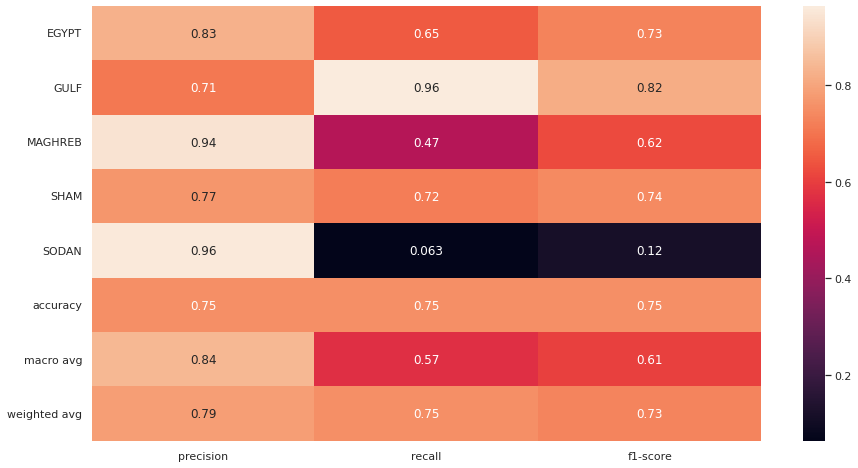

In [65]:
plt.figure(figsize=(15,8));
sb.heatmap(pd.DataFrame(NB_CR).iloc[:-1, :].T, annot=True);

#### Support Vector Machines Model

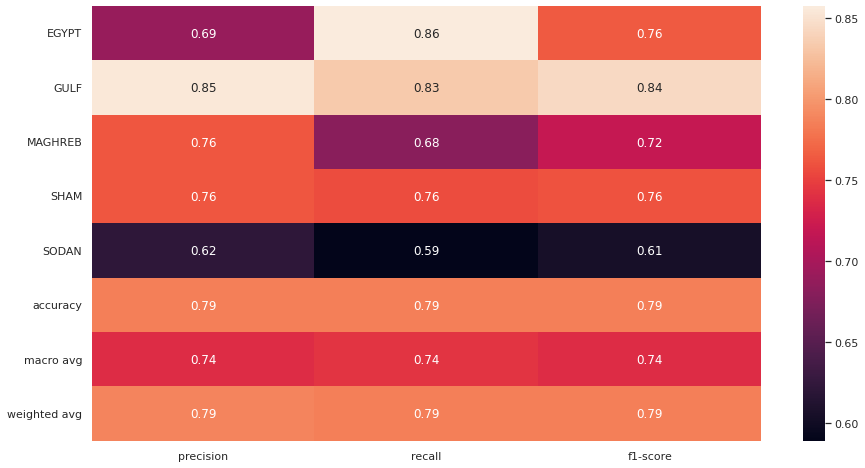

In [66]:
plt.figure(figsize=(15,8));
sb.heatmap(pd.DataFrame(SVM_CR).iloc[:-1, :].T, annot=True);

#### Logestic Regression Model

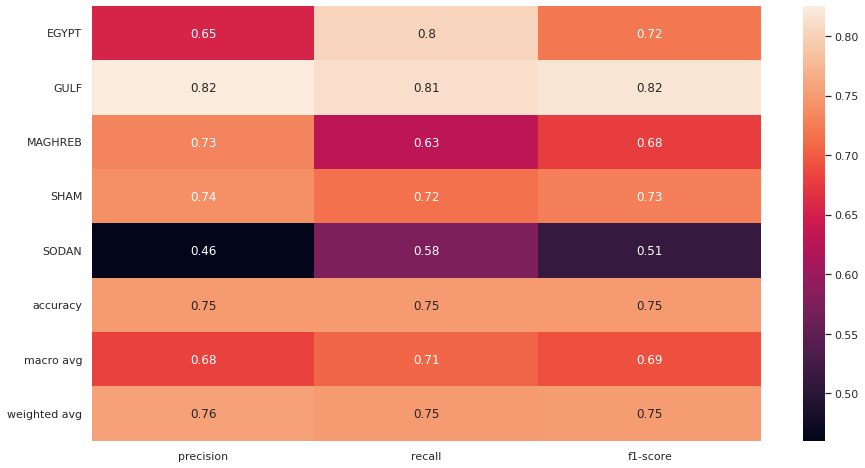

In [67]:
plt.figure(figsize=(15,8));
sb.heatmap(pd.DataFrame(LR_CR).iloc[:-1, :].T, annot=True);